In [1]:
from PIL import Image
import numpy as np
import numpy.linalg as la
import math
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
def show_image(image, n=8):
    plt.figure(figsize=(n,n))
    plt.grid(False)
    plt.gray()
    plt.axis('on')
    plt.imshow(image)
    plt.show()

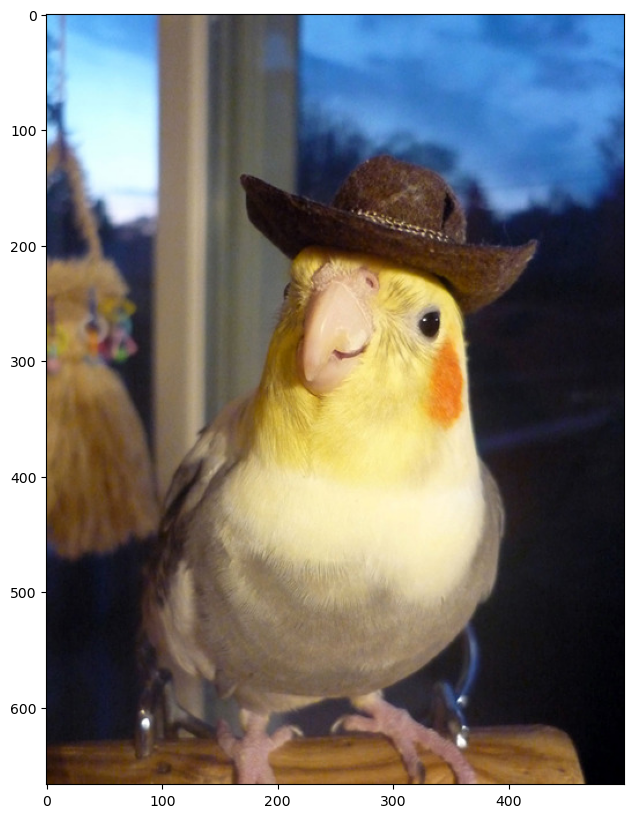

In [3]:
img1 = r"C:\Users\Owner\Downloads\parrot.jpg"
img1 = load_img(img1)
show_image(img1,10)

In [4]:
img_array = img_to_array(img1)
print(img_array.shape)
img_array = 1/255.0 * img_array.flatten().reshape(img_array.shape[0], img_array.shape[1],img_array.shape[2])

(667, 500, 3)


In [5]:
blur_radius = 6 # range [1, 6]
st = np.zeros((img_array.shape[0], 2*blur_radius + img_array.shape[1],4))
img_array = np.pad(img_array, ((1,1), (1,1), (0, 0)), mode='constant')
for y_ in range(len(st)):
    for x_ in range(len(st[0]) - 2*blur_radius):
        y, x = y_+1, x_+1
        
        Sx = np.zeros(3)
        Sy = np.zeros(3)
    
        Sx = (1.0 * img_array[y-1][x-1] + 
          2.0 * img_array[y][x-1] +
          1.0 * img_array[y+1][x-1] -
          1.0 * img_array[y-1][x+1] -
          2.0 * img_array[y][x+1] -
          1.0 * img_array[y+1][x+1]) / 4.0
    
        Sy = (1.0 * img_array[y-1][x-1] + 
          2.0 * img_array[y-1][x] +
          1.0 * img_array[y-1][x+1] -
          1.0 * img_array[y+1][x-1] -
          2.0 * img_array[y+1][x] -
          1.0 * img_array[y+1][x+1]) / 4.0
        
        st[y_][blur_radius + x_] = np.array([np.dot(Sx, Sx), np.dot(Sy, Sy), np.dot(Sx, Sy), 1.0])

In [10]:
res = 255*st[:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-175.24170219898224..611.855206489563].


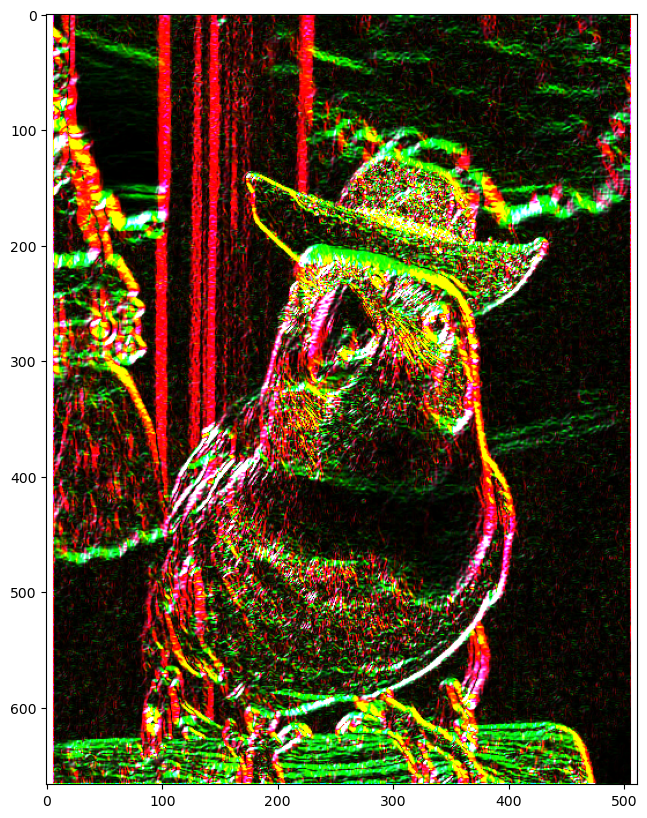

In [11]:
show_image(res,10)

In [12]:
bst = np.zeros((st.shape[0] + 2*blur_radius, st.shape[1] - 2*blur_radius, 4))
AFX_PI = 3.14159265358979323846
def gaussian(sigma, pos):
    return (1.0 / math.sqrt(2.0 * AFX_PI * sigma * sigma)) * np.exp(-(pos * pos) / (2.0 * sigma * sigma))

gauss_table = np.zeros(2 * blur_radius + 1)
for i in range(-blur_radius, blur_radius+1):
    gauss_table[i] = gaussian(2.0, i)

kernel_sum = np.sum(gauss_table)
for y in range(len(bst) - 2*blur_radius):
    for x in range(len(bst[0])):
        y_, x_ = y, x + blur_radius
        for i in range(-blur_radius, blur_radius+1):
            bst[y+blur_radius][x] += gauss_table[i] * st[y_][x_ + i]
        bst[y + blur_radius][x] /= kernel_sum

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.090089021458496..453.2243392173014].


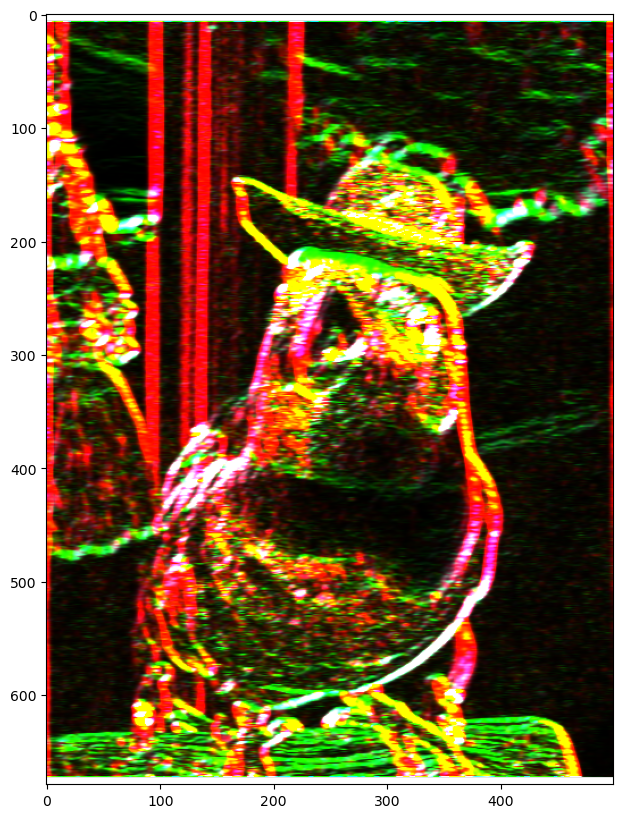

In [13]:
res = 255*bst[:,:, 0:4]
show_image(res,10)

In [14]:
cs = np.zeros((bst.shape[0] - 2*blur_radius, bst.shape[1], 4))

for y in range(len(cs)):
    for x in range(len(cs[0])):
        y_, x_ = y+blur_radius, x
        for j in range(-blur_radius, blur_radius+1):
            cs[y][x] += gauss_table[j] * bst[y_+j][x_]
        cs[y][x] /= kernel_sum

        gx = cs[y][x][0]
        gy = cs[y][x][1]
        gz = cs[y][x][2]

        root = math.sqrt(gy * gy - 2.0 * gx * gy + gx * gx + 4.0 * gz * gz)
        lambda1 = 0.5 * (gy + gx + root)
        lambda2 = 0.5 * (gy + gx - root)
        v = np.array([lambda1 - gx, -gz])
        magnitude = la.norm(v)
        if magnitude > 0.0:
            t = v / magnitude
        else:
            t = np.array([0.0, 1.0])
        #t = magnitude > 0.0 ? v / magnitude : np.array([0.0, 1.0])
        ty, tx = t[1], t[0]
        phi = -math.atan2(ty, tx)
        if (lambda1 + lambda2 > 0.0):
            A = (lambda1 - lambda2) / (lambda1 + lambda2)
        else:
            A = 0
        #A = (lambda1 + lambda2 > 0.0) ? (lambda1 - lambda2) / (lambda1 + lambda2) : 0.0

        cs[y][x] = np.array([t[0], t[1], phi, A])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.570792458694235..1.5707898565245482].


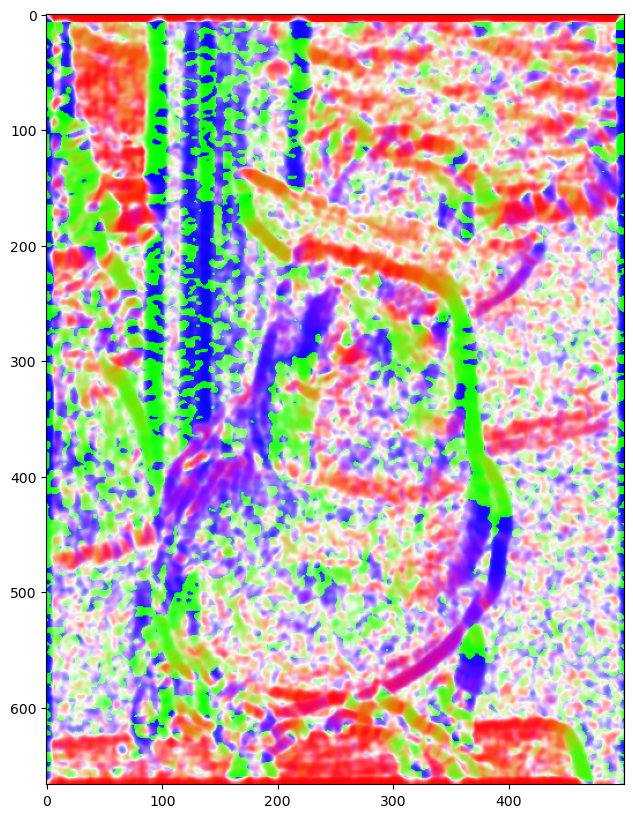

In [15]:
res = cs[:,:, 0:4]
show_image(res,10)

In [79]:
def clamp(val, a, b):
    if val < a:
        return a
    if val > b:
        return b
    return val

img_array = img_to_array(img1)
img_array = 1/255.0*img_array.flatten().reshape(img_array.shape[0], img_array.shape[1],img_array.shape[2])

output = np.zeros((cs.shape[0], cs.shape[1], 4))

alpha = 1.0 # range [0.01, 2.0]
_KernelSize = 8 # range [2, 30]
_N = 8 # Number of sectors
radius = _KernelSize / 2
_ZeroCrossing = 0.58 # range [0.01, 2.0]
_Q = 8 # range [0, 18]

pad = 0#*int(_KernelSize/2)
#img_array = np.pad(img_array, ((pad,pad), (pad,pad), (0, 0)), mode='constant')

#if (_DepthAware)
#    radius = round(lerp(_MinKernelSize / 2.0f, _KernelSize / 2.0f, smoothstep(0.0f, 1.0f, depth)));

for y_ in range(len(output)):
    for x_ in range(len(output[0])):
        t = cs[y_][x_]
        tw = t[3]
        tz = t[2]
        
        a = radius * clamp((alpha + tw) / alpha, 0.1, 2.0)
        b = radius * clamp(alpha / (alpha + tw), 0.1, 2.0)

        cos_phi = math.cos(tz)
        sin_phi = math.sin(tz)
        R = np.array([[cos_phi, -sin_phi],
                      [sin_phi, cos_phi]])
        S = np.array([[0.5 / a, 0.0],
                      [0.0, 0.5 / b]])
        SR = S @ R
        max_x = int(math.sqrt(a * a * cos_phi * cos_phi + b * b * sin_phi * sin_phi))
        max_y = int(math.sqrt(a * a * sin_phi * sin_phi + b * b * cos_phi * cos_phi))

        zeta = 2.0 / (_KernelSize / 2)

        zeroCross = _ZeroCrossing
        sinZeroCross = math.sin(zeroCross)
        eta = (zeta + math.cos(zeroCross)) / (sinZeroCross * sinZeroCross)
        
        m = np.zeros((8, 4))#float4 m[8]
        s = np.zeros((8, 3))#float3 s[8]
        
        for y in range(-max_y, max_y+1):
            for x in range(-max_x, max_x+1):
                v = SR @ np.array([x, y])
                vx = v[0]
                vy = v[1]
                
                if np.dot(v, v) <= 0.25:
                    c = img_array[clamp(y_+y, 0, len(output)-1)][clamp(x_+x, 0, len(output[0])-1)]
                    summ = 0
                    w = np.zeros(8)

                    # calculate polynomial weights
                    vxx = zeta - eta * vx * vx
                    vyy = zeta - eta * vy * vy
                    z = max(0, vy + vxx)
                    w[0] = z * z
                    summ += w[0]
                    z = max(0, -vx + vyy)
                    w[2] = z * z
                    summ += w[2]
                    z = max(0, -vy + vxx) 
                    w[4] = z * z
                    summ += w[4]
                    z = max(0, vx + vyy) 
                    w[6] = z * z
                    summ += w[6]
                    
                    v = math.sqrt(2.0) / 2.0 * np.array([vx - vy, vx + vy])
                    vx = v[0]
                    vy = v[1]
                    
                    vxx = zeta - eta * vx * vx
                    vyy = zeta - eta * vy * vy
                    z = max(0, vy + vxx)
                    w[1] = z * z
                    summ += w[1]
                    z = max(0, -vx + vyy)
                    w[3] = z * z
                    summ += w[3]
                    z = max(0, -vy + vxx) 
                    w[5] = z * z
                    summ += w[5]
                    z = max(0, vx + vyy)
                    w[7] = z * z
                    summ += w[7]

                    g = np.exp(-3.125 * np.dot(v,v)) / summ

                    for k in range(8):
                        wk = w[k] * g
                        m[k] += wk * np.array([c[0], c[1], c[2], 1.0])
                        s[k] += wk * (c * c)

        for k in range(_N):
            rgb = np.array([m[k][0], m[k][1], m[k][2]]) / m[k][3]
            s[k] = abs(s[k] / m[k][3] - (rgb * rgb))

            sigma2 = s[k][0] + s[k][1] + s[k][2]
            w = 1.0 / (1.0 + math.pow(abs(1000.0 * sigma2), 0.5 * _Q))
            output[y_][x_] += w * np.array([rgb[0], rgb[1], rgb[2], 1])

        output[y_][x_] /= output[y_][x_][3]

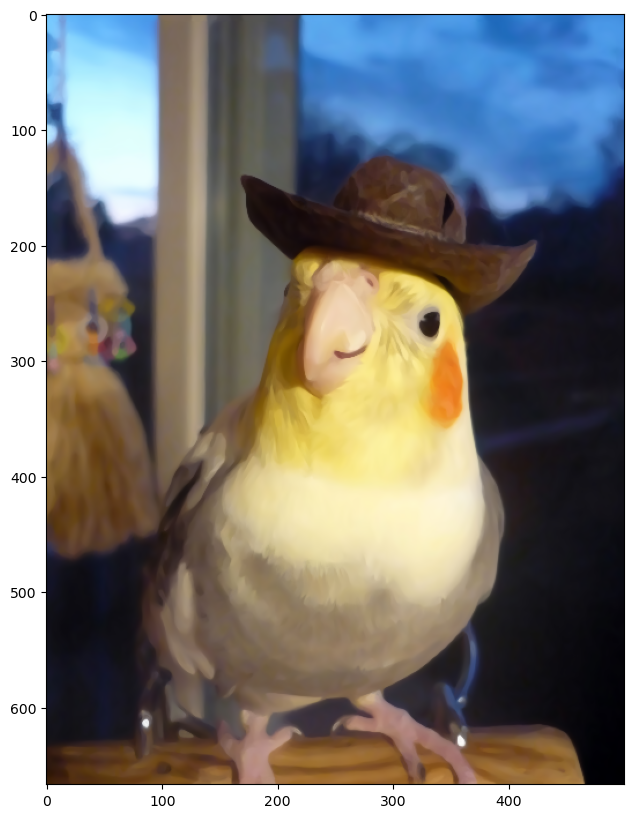

In [86]:
res = output
show_image(res,10) #.astype(np.uint8)

In [89]:
import matplotlib.image

matplotlib.image.imsave('name.png', res)
